#### DOMAIN:
- Entertainment
#### CONTEXT:
- Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done.
#### DATA DESCRIPTION:
- The dataset comprises of images and its mask for corresponding human face.
####  PROJECT OBJECTIVE:
- To build a face detection system.


#### 1.Import and Understand the data
##### Q1A: Import and read ‘images.npy’.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Import necessary libraries
import re
import numpy as np
from PIL import Image
import cv2
import random

image_data = np.load('/content/drive/MyDrive/AIML_Program/ComputerVision/Project/Images.npy', allow_pickle=True)

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

In [4]:
#print the shape of the image array
print(image_data.shape)

(393, 2)


In [5]:
image_data[0][0].shape

(333, 650, 3)

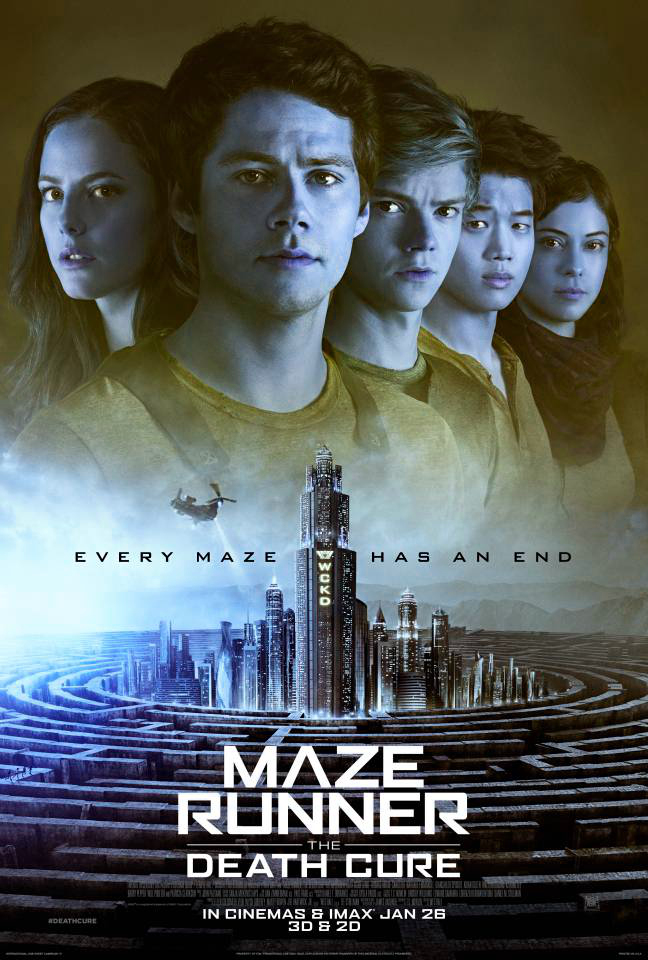

In [6]:
#Print a random image from image_data array
from google.colab.patches import cv2_imshow

cv2_imshow(image_data[10][0])

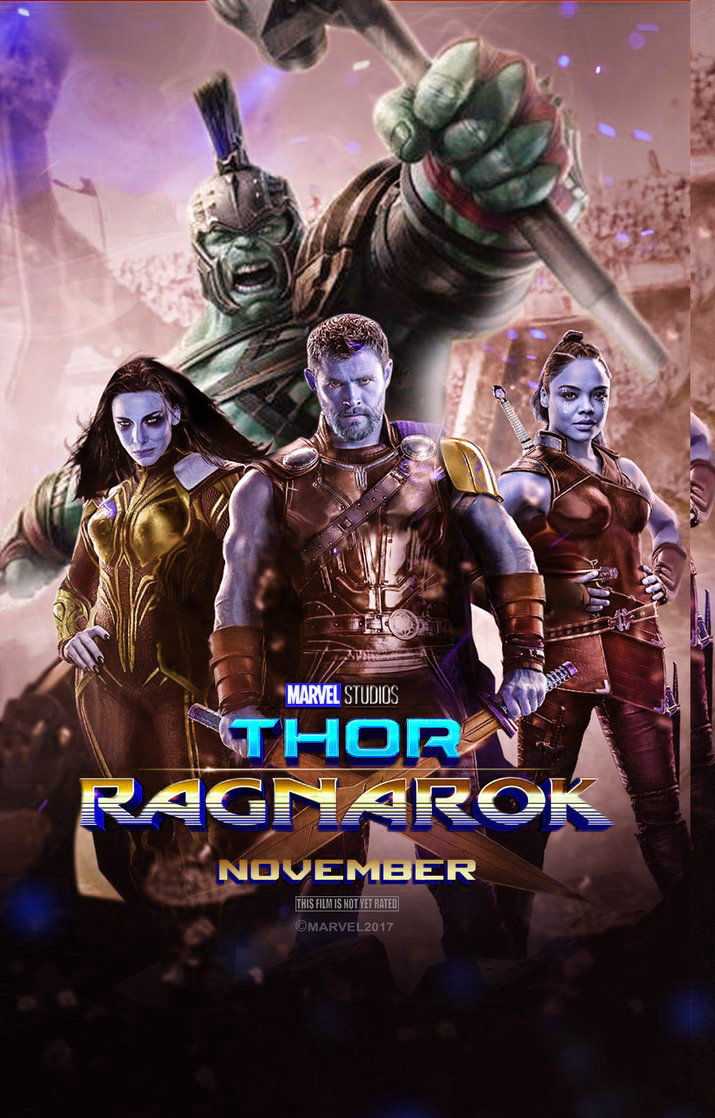

In [7]:
#Print another random image from the list
cv2_imshow(image_data[31][0])

#### Q1B: Split the data into Features(X) & labels(Y). Unify shape of all the images

In [8]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(image_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(image_data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(image_data.shape[0]):
  img = image_data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  """ assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel.
  The alpha channel is a special channel that handles transparency. When an image has an alpha channel on it,
  it means you can adjust the image's opacity levels and make bits translucent or totally see-through.
  The alpha channel is instrumental when you want to remove the background from an image."""
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in image_data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 260 Grayscale image with shape (224, 224)
### Shape of X is '(393, 224, 224, 3)' and the shape of mask is '(393, 224, 224)' 


#### Q1C: Split the data into train and test (70:30 ratio).

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(275, 224, 224, 3)' and the shape of y_train is '(275, 224, 224)'
Shape of X_val is '(82, 224, 224, 3)' and the shape of y_val is '(82, 224, 224)'
Shape of X_test is '(36, 224, 224, 3)' and the shape of y_test is '(36, 224, 224)'


#### Q1D: Select random image from the train data and display original image and masked image.

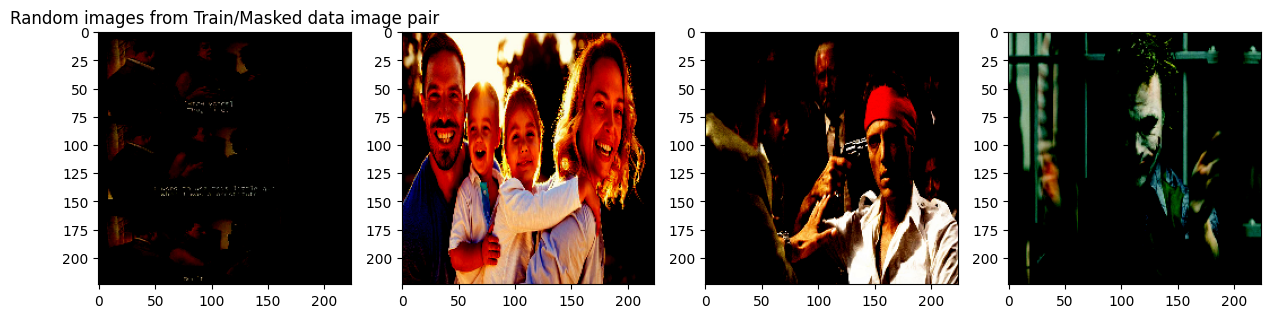

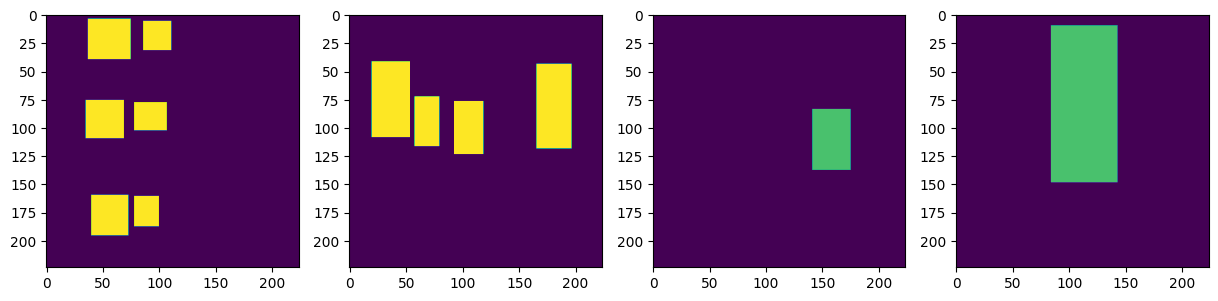

In [10]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
plt.title("Random images from Train/Masked data image pair")
imgplot = plt.imshow(X_train[1])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[16])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[29])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[83])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[1])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[16])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[29])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[83])
imgplot.set_clim(0.0, 1.4)

### Q2: Model Building
#### Q2A: Design a face mask detection model.

#### Addding MobileNet as model with below parameter values
- input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
- include_top: False
- alpha: 1.0
- weights: "imagenet"
- Adding UNET architecture layers

In [11]:
IMAGE_SIZE = 224
EPOCHS = 20
BATCH = 8
LR = 1e-4

In [12]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [13]:
model = create_model()

17225924/17225924 [==============================] - 2s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

#### Q2B:  Design your own Dice Coefficient and Loss function.

In [15]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

#### Compiling the model using below parameters.
- loss: using the loss function defined above
- optimizer: using Adam optimizer
- metrics: using dice_coefficient function defined above

In [16]:
model.compile(loss=dice_loss, optimizer='adam', metrics=[dice_coef])

#### Defining callbacks
- Using ModelCheckpoint
- Using EarlyStopping
- Using ReduceLROnPlateau

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the filepath with .weights.h5 extension
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

#### Q2C:Train and tune the model as required.
- Fitting the model using below parameters¶
  - epochs: 20
  - batch_size: 8
  - callbacks: using the callbacks defined above

In [18]:
model.fit(X_train, y_train, epochs=20, batch_size=8, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.4998 - dice_coef: 0.4975
Epoch 1: loss improved from inf to 0.49984, saving model to model-0.50.weights.h5
35/35 [==============================] - 31s 355ms/step - loss: 0.4998 - dice_coef: 0.4975 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.4088 - dice_coef: 0.5915
Epoch 2: loss improved from 0.49984 to 0.40875, saving model to model-0.41.weights.h5
35/35 [==============================] - 10s 296ms/step - loss: 0.4088 - dice_coef: 0.5915 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.3802 - dice_coef: 0.6196
Epoch 3: loss improved from 0.40875 to 0.38021, saving model to model-0.38.weights.h5
35/35 [==============================] - 11s 302ms/step - loss: 0.3802 - dice_coef: 0.6196 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.3179 - dice_coef: 0.6834
Epoch 4: loss improved from 0.38021 to 0.31788, saving

#### Lets tune with SGD optimizer

In [21]:
from tensorflow.keras.optimizers import Adam, SGD
model.compile(loss=dice_loss, optimizer=SGD(learning_rate=0.0010, momentum=0.9), metrics=[dice_coef])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the filepath with .weights.h5 extension
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [23]:
#Lets Train the model
model.fit(X_train, y_train, epochs=20, batch_size=8, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.1435 - dice_coef: 0.8576
Epoch 1: loss improved from inf to 0.14346, saving model to model-0.14.weights.h5
35/35 [==============================] - 18s 294ms/step - loss: 0.1435 - dice_coef: 0.8576 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.1411 - dice_coef: 0.8573
Epoch 2: loss improved from 0.14346 to 0.14109, saving model to model-0.14.weights.h5
35/35 [==============================] - 10s 294ms/step - loss: 0.1411 - dice_coef: 0.8573 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.1438 - dice_coef: 0.8554
Epoch 3: loss did not improve from 0.14109
35/35 [==============================] - 10s 283ms/step - loss: 0.1438 - dice_coef: 0.8554 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.1399 - dice_coef: 0.8594
Epoch 4: loss improved from 0.14109 to 0.13989, saving model to model-0.14.weights.h5
35/35 [====

#### Lets tune with batch size 4 and LR:0.01

In [24]:
from tensorflow.keras.optimizers import Adam, SGD
model.compile(loss=dice_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[dice_coef])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the filepath with .weights.h5 extension
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [30]:
#Lets Train the model with batch size:32
model.fit(X_train, y_train, epochs=20, batch_size=4, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 0.1491 - dice_coef: 0.8509
Epoch 1: loss improved from inf to 0.14908, saving model to model-0.15.weights.h5
69/69 [==============================] - 19s 204ms/step - loss: 0.1491 - dice_coef: 0.8509 - lr: 0.0100
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.1492 - dice_coef: 0.8508
Epoch 2: loss did not improve from 0.14908
69/69 [==============================] - 10s 144ms/step - loss: 0.1492 - dice_coef: 0.8508 - lr: 0.0100
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.1470 - dice_coef: 0.8527
Epoch 3: loss improved from 0.14908 to 0.14705, saving model to model-0.15.weights.h5
69/69 [==============================] - 10s 150ms/step - loss: 0.1470 - dice_coef: 0.8527 - lr: 0.0100
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.1500 - dice_coef: 0.8498
Epoch 4: loss did not improve from 0.14705
69/69 [==============================] - 10s 146ms/ste

#### Lets tune with Adam optimizer, LR=0.01, batch size:4

In [34]:
model.compile(loss=dice_loss, optimizer=Adam(learning_rate=0.01), metrics=[dice_coef])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the filepath with .weights.h5 extension
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [38]:
model.fit(X_train, y_train, epochs=20, batch_size=4, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 0.2685 - dice_coef: 0.7318
Epoch 1: loss improved from 0.28670 to 0.26848, saving model to model-0.27.weights.h5
69/69 [==============================] - 11s 154ms/step - loss: 0.2685 - dice_coef: 0.7318 - lr: 0.0100
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.2604 - dice_coef: 0.7399
Epoch 2: loss improved from 0.26848 to 0.26044, saving model to model-0.26.weights.h5
69/69 [==============================] - 10s 151ms/step - loss: 0.2604 - dice_coef: 0.7399 - lr: 0.0100
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.2677 - dice_coef: 0.7322
Epoch 3: loss did not improve from 0.26044
69/69 [==============================] - 10s 147ms/step - loss: 0.2677 - dice_coef: 0.7322 - lr: 0.0100
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.2789 - dice_coef: 0.7210
Epoch 4: loss did not improve from 0.26044
69/69 [==============================] - 10s 146ms

#### Lets tune with SGD optimizer, LR=0.01 and momentum=0.9, batch size:4

In [49]:
from tensorflow.keras.optimizers import Adam, SGD
model.compile(loss=dice_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[dice_coef])

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the filepath with .weights.h5 extension
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [51]:
#Lets Train the model with batch size:32
model.fit(X_train, y_train, epochs=20, batch_size=4, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 0.2252 - dice_coef: 0.7748
Epoch 1: loss improved from inf to 0.22521, saving model to model-0.23.weights.h5
69/69 [==============================] - 16s 151ms/step - loss: 0.2252 - dice_coef: 0.7748 - lr: 0.0100
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.2138 - dice_coef: 0.7861
Epoch 2: loss improved from 0.22521 to 0.21380, saving model to model-0.21.weights.h5
69/69 [==============================] - 10s 149ms/step - loss: 0.2138 - dice_coef: 0.7861 - lr: 0.0100
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.2204 - dice_coef: 0.7793
Epoch 3: loss did not improve from 0.21380
69/69 [==============================] - 10s 143ms/step - loss: 0.2204 - dice_coef: 0.7793 - lr: 0.0100
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.2240 - dice_coef: 0.7748
Epoch 4: loss did not improve from 0.21380
69/69 [==============================] - 10s 145ms/ste

#### Q2D: Evaluate and share insights on performance of the model.

#### Base Architecture contains Mobilenet with imagenet weights and added UNET architecture layers.
- For all models we used, model checkpoints along with EarlyStopping and ReduceLRonPlateau, epochs:20
- Model-1: Optimizer:Adam, Learning Rate:0.0010,  Batch Size=8
  Dice Loss=0.1452, Dice Coeff: 0.8547. Dice Coeff seems to be good.

- Model-2: Optimizer:SGD, Learning Rate:0.0010, momentum=0.9, Batch Size=8
  Dice Loss=0.1380, Dice Coeff: 0.8618. We can see that Dice loss decreased and Dice coeff increased slightly compared to Model-1.

- Model-3: Optimizer:SGD, Learning Rate:0.01, momentum=0.9, Batch Size=4
  Dice Loss=0.1315, Dice Coeff: 0.8684. We can see that Dice loss decreased and Dice coeff increased marginally compared to Model-2.

- Model-4: Optimizer:Adam, Learning Rate:0.01,  Batch Size=4
  Dice Loss=0.2400, Dice Coeff: 0.7600. Dice loss increased and coeff decreased from all previous models.

- Furthur when we tried with Batch size=8, 16 values with Optimizers SGD and Adam combined with Learning Rate=0.01, we see OOM errors due to resource exhaustation and couldnt try furthur improvements.



#### Overall MODEL-3(SGD Optimizer=Adam, LR=0.01 with momentum=0.9, Batchsize=4) giving us better results among the other model and seems to be the best model for this current dataset.

#### Q3: Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

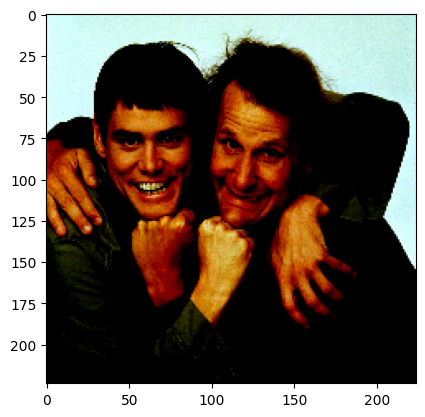

In [52]:
#Showing the test image
index = 3
plt.imshow(X_test[index])

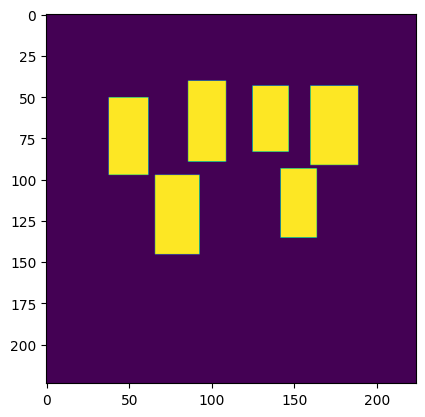

In [53]:
#Get original mask for image under test
plt.imshow(masks[index])

In [54]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[index]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))

1/1 [==============================] - 0s 471ms/step


#### Impose the mask on test image
- Using imshow and  alpha parameter set to 0.9, visualize the image with mask.

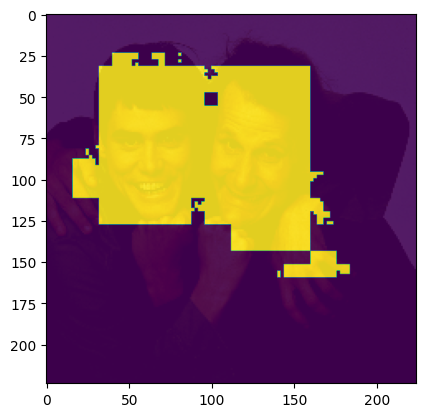

In [55]:
plt.imshow(X_test[index])
plt.imshow(pred_mask, alpha=0.9)

#### END OF PART-A OF PROJECT #############